In [16]:
import pandas as pd
import numpy as np
import ast
import re
import math
import json
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# read in the json files
portfolio = pd.read_excel('../misc/portfolio-301124-000042.xlsx')   
portfolio.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
profile = pd.read_excel('../misc/profile-301124-000042.xlsx')   
profile.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
# transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [32]:
# Load data from previously generated offer_agg dataframe (stored in XLSX format)
offer_agg = pd.read_excel('../misc/offer_agg-301124-000042.xlsx')   
offer_agg.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

 # Exploratory Data Analysis

In [33]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby('offer_id').agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

print(result.columns)

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)


result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']

Index(['offer_id', 'offer_rcvd_time', 'offer_view_time', 'offer_cmpl_time',
       'offer_trx_amount'],
      dtype='object')


In [34]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,2,1,22.88,5.720000,22.880000
1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,0.00,0.000000,NaN
2,2906b810c7d4411798c6938adc9daaa5,4,2,3,47.35,11.837500,15.783333
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,2,3,40.84,13.613333,13.613333
4,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,14.48,14.480000,14.480000
5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,1,7.24,7.240000,7.240000
6,fafdcd668e3743c1bb461111dcafc2a4,3,3,3,28.46,9.486667,9.486667


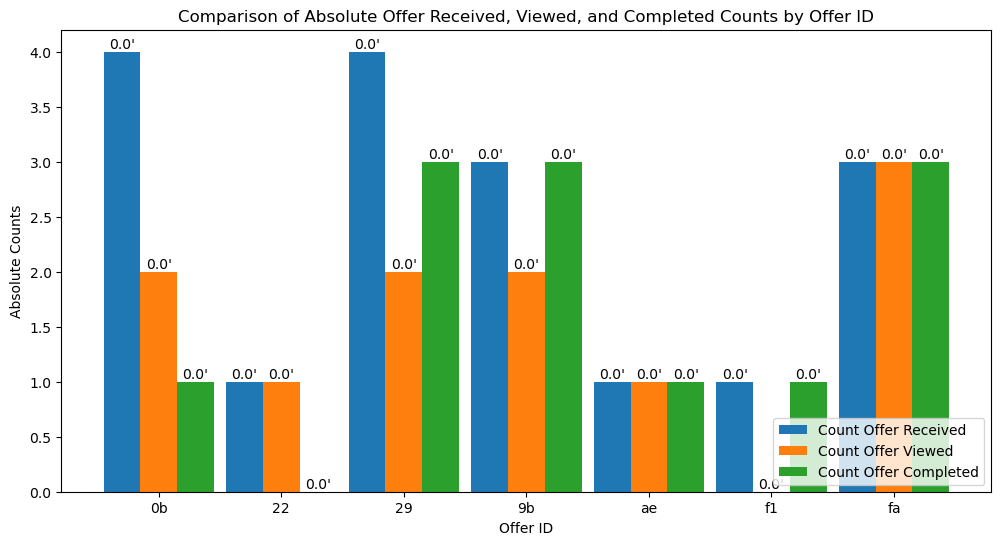

In [35]:
# Create a bar graph to compare absolute values of count_offer_rcvd, count_offer_view, count_offer_cmpl for each offer_id

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.3

# Plot the bars
bars1 = plt.bar(positions, result['count_offer_rcvd'], width=width, label='Count Offer Received')
bars2 = plt.bar([p + width for p in positions], result['count_offer_view'], width=width, label='Count Offer Viewed')
bars3 = plt.bar([p + width * 2 for p in positions], result['count_offer_cmpl'], width=width, label='Count Offer Completed')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval/1000:.1f}'", ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Absolute Counts')
plt.title('Comparison of Absolute Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend and move it to the bottom right corner
plt.legend(loc='lower right')

# Show the plot
plt.show()

### Absolute counts of offer received, offer viewed and offer completed

*Distribution of offer ids in transcript dataset:* <br>
*As the bar graphs above are showing the various offers are nearly evenly distributed in the transcript data set.*
<br><br>
*Count offer views vs. count offer completed anomaly:* <br>
*For offers '0b', '29', '9b' there are many offers, which are not viewed prior to their completion. This was already detected in the test data (see discusion above).*

In [36]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,duration_hours,reward_difficulty_quotient
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1.00
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1.00
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,96,NaN
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1.00
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,0.25
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168,0.43
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240,0.20
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72,NaN
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1.00
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,168,0.20


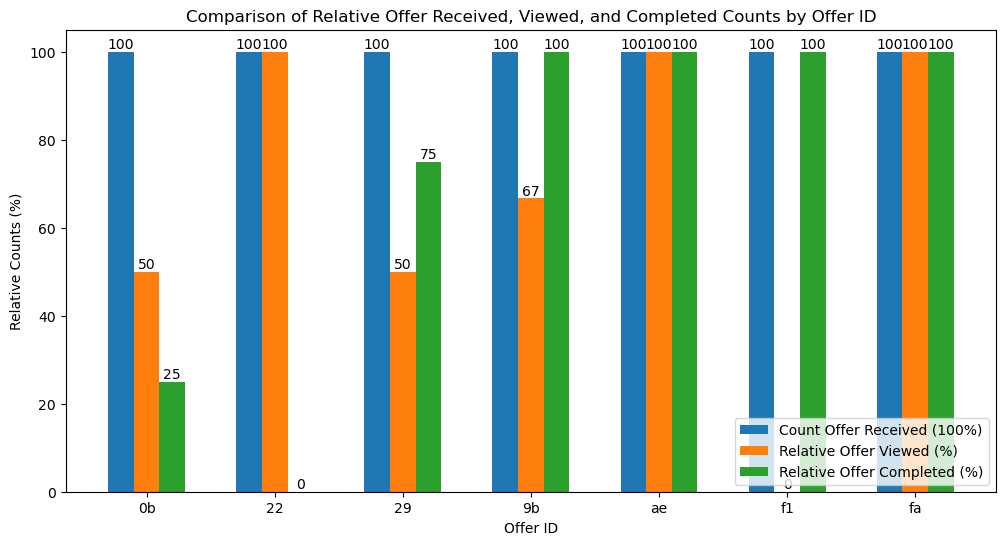

In [37]:
import matplotlib.pyplot as plt

# Create a bar graph to compare count_offer_view, count_offer_cmpl for each offer_id relatively to count_offer_rcvd

# Calculate relative values where count_offer_rcvd is 100%
result['relative_offer_view'] = (result['count_offer_view'] / result['count_offer_rcvd']) * 100
result['relative_offer_cmpl'] = (result['count_offer_cmpl'] / result['count_offer_rcvd']) * 100

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
width = 0.2

# Plot the bars
bars1 = plt.bar(positions, [100] * len(result), width=width, label='Count Offer Received (100%)')
bars2 = plt.bar([p + width for p in positions], result['relative_offer_view'], width=width, label='Relative Offer Viewed (%)')
bars3 = plt.bar([p + width * 2 for p in positions], result['relative_offer_cmpl'], width=width, label='Relative Offer Completed (%)')

# Add the values on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Relative Counts (%)')
plt.title('Comparison of Relative Offer Received, Viewed, and Completed Counts by Offer ID')
plt.xticks([p + width for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [38]:
result

,offer_id,count_offer_rcvd,count_offer_view,count_offer_cmpl,sum_offer_trx_amount,trx_amount_per_offer_rcvd,trx_amount_per_offer_compl,relative_offer_view,relative_offer_cmpl
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,4,2,1,22.88,5.720000,22.880000,50.000000,25.0
1,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,0,0.00,0.000000,NaN,100.000000,0.0
2,2906b810c7d4411798c6938adc9daaa5,4,2,3,47.35,11.837500,15.783333,50.000000,75.0
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,3,2,3,40.84,13.613333,13.613333,66.666667,100.0
4,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,14.48,14.480000,14.480000,100.000000,100.0
5,f19421c1d4aa40978ebb69ca19b0e20d,1,0,1,7.24,7.240000,7.240000,0.000000,100.0
6,fafdcd668e3743c1bb461111dcafc2a4,3,3,3,28.46,9.486667,9.486667,100.000000,100.0


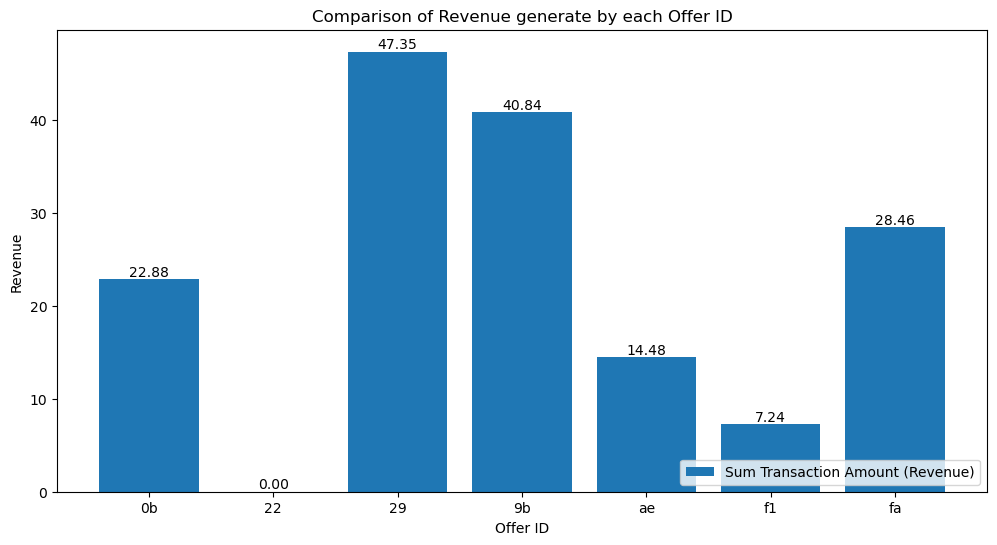

In [39]:
# Create a bar graph to show a comparison of total revenues generate by each offer

# Set the figure size
plt.figure(figsize=(12, 6))

# Set the positions and width for the bars
positions = range(len(result))
# width = 0.2

# Plot the bars
plt.bar(positions, result['sum_offer_trx_amount'], label='Sum Transaction Amount (Revenue)')

# Add the values on top of each bar
for i, value in enumerate(result['sum_offer_trx_amount']):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

# Set the x-axis labels and positions
plt.xlabel('Offer ID')
plt.ylabel('Revenue')
plt.title('Comparison of Revenue generate by each Offer ID')
plt.xticks([p for p in positions], result['offer_id'].str[:2])

# Add legend
plt.legend(loc='lower right')

# Show the plot
plt.show() 

### Overall performance of the offers based on absolute revenue and relative completion rate

*Relative completion rate:* <br>
*As the bar graphs above are showing the most successful offers regarding relative completion rate are the offers starting with ID 'fa', '22' and '9b'/'f1'.*
<br><br>
*Absolute revenue:* <br>
*Regarding absolute revenue generated the offers 'fa', 'ae' and '22' are the most successful. It is interesting, that offer 'ae' as a relatively low completion rate (47%), but generates the second highest revenue.*

In [40]:
portfolio['reward_difficulty_quotient'] = round(portfolio['reward'] / portfolio['difficulty'], 2)
portfolio

,reward,channels,difficulty,duration,offer_type,id,duration_hours,reward_difficulty_quotient
0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,168,1.00
1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,120,1.00
2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed,96,NaN
3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,168,1.00
4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,240,0.25
5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,168,0.43
6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,240,0.20
7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837,72,NaN
8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,120,1.00
9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5,168,0.20


In [41]:
offer_agg.head(10)

,person,gender,gender_M,gender_F,age,age_group,age_group_36-45,age_group_56-65,age_group_66-75,became_member_on,...,offer_reward,offer_channels,offer_channels_web,offer_channels_email,offer_channels_mobile,offer_channels_social,offer_type,offer_type_bogo,offer_type_discount,offer_trx_amount
0,78afa995795e4d85b5d9ceeca43f5fef,F,0,1,75.0,66-75,0,0,1,2017-05-09,...,5,"['web', 'email', 'mobile']",1,1,1,0,bogo,1,0,19.89
1,78afa995795e4d85b5d9ceeca43f5fef,F,0,1,75.0,66-75,0,0,1,2017-05-09,...,10,"['email', 'mobile', 'social']",0,1,1,1,bogo,1,0,14.48
2,78afa995795e4d85b5d9ceeca43f5fef,F,0,1,75.0,66-75,0,0,1,2017-05-09,...,5,"['web', 'email', 'mobile', 'social']",1,1,1,1,bogo,1,0,7.24
3,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,NaN,NaN,0,0,0,2017-08-04,...,5,"['web', 'email']",1,1,0,0,discount,0,1,NaN
4,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,NaN,NaN,0,0,0,2017-08-04,...,5,"['web', 'email']",1,1,0,0,discount,0,1,NaN
5,a03223e636434f42ac4c3df47e8bac43,NaN,0,0,NaN,NaN,0,0,0,2017-08-04,...,5,"['web', 'email']",1,1,0,0,discount,0,1,NaN
6,e2127556f4f64592b11af22de27a7932,M,1,0,68.0,66-75,0,0,1,2018-04-26,...,2,"['web', 'email', 'mobile']",1,1,1,0,discount,0,1,NaN
7,e2127556f4f64592b11af22de27a7932,M,1,0,68.0,66-75,0,0,1,2018-04-26,...,5,"['web', 'email', 'mobile']",1,1,1,0,bogo,1,0,13.16
8,e2127556f4f64592b11af22de27a7932,M,1,0,68.0,66-75,0,0,1,2018-04-26,...,2,"['web', 'email', 'mobile', 'social']",1,1,1,1,discount,0,1,5.26
9,2eeac8d8feae4a8cad5a6af0499a211d,M,1,0,58.0,56-65,0,1,0,2017-11-11,...,3,"['web', 'email', 'mobile', 'social']",1,1,1,1,discount,0,1,NaN


In [42]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   gender            14825 non-null  object        
 1   age               14825 non-null  float64       
 2   id                17000 non-null  object        
 3   became_member_on  17000 non-null  datetime64[ns]
 4   income            14825 non-null  float64       
 5   age_group         14825 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 797.0+ KB


In [43]:
profile[(profile['gender'].isna()) & (profile['income'].isna()) & (profile['age'] == 118)]

,gender,age,id,became_member_on,income,age_group


In [44]:
# Group dataframe offer_agg by 'offer_id' and aggregate the required columns
result = offer_agg.groupby(['offer_id']).agg({
    'offer_rcvd_time': 'count',
    'offer_view_time': 'count',
    'offer_cmpl_time': 'count',
    'offer_trx_amount': 'sum'
}).reset_index()

# Rename columns to match the desired names
result.rename(columns={
    'offer_rcvd_time': 'count_offer_rcvd',
    'offer_view_time': 'count_offer_view',
    'offer_cmpl_time': 'count_offer_cmpl',
    'offer_trx_amount': 'sum_offer_trx_amount'
}, inplace=True)

print(result.columns)



result['trx_amount_per_offer_rcvd'] = result['sum_offer_trx_amount'] / result['count_offer_rcvd']
result['trx_amount_per_offer_compl'] = result['sum_offer_trx_amount'] / result['count_offer_cmpl']

Index(['offer_id', 'count_offer_rcvd', 'count_offer_view', 'count_offer_cmpl',
       'sum_offer_trx_amount'],
      dtype='object')
